# Reading the data of ASCII XYZ datasets

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

%matplotlib inline

In [2]:
import sys
import importlib
import os
sys.path.append('../../modules')
from processing import interpolate
from plotting import interpolate_plotting
importlib.reload(interpolate);

In [3]:
data_dir = os.path.join('..', '..', 'data')
output_dir = os.path.join('..', '..', 'output')

# Magnetic Data

In [4]:
blocks = []
block_ids = []

with open('../../data/magnetic/PAC_MAG_NORTE/PAC_MAG_NORTE.xyz') as f:
    lines = f.readlines()

columns = lines[1].strip().split()
current_block = None

for line in lines[2:]:
    if line.startswith('line'):
        current_block = line.strip()
        continue
    values = line.strip().split()
    if len(values) == len(columns):
        blocks.append(values)
        block_ids.append(current_block)

df = pd.DataFrame(blocks, columns=columns)
df['block'] = block_ids
df;

In [5]:
df = df.astype({
    '/FID': int,
    'JDAY': int,
    'TIME': str,
    'X': float,
    'Y': float,
    'LAT': float,
    'LONG': float,
    'RAW_ALT': float,
    'ADJ_ALT': float,
    'RADAR': float,
    'TERRAIN': float,
    'DIURNAL': float,
    'IGRF': float,
    'OBSMAG': float,
    'TMI_MAG': float,
    'block': str
})

def convert_time_to_seconds(time_str):
    """Convierte un string de tiempo HHMMSS.ss a segundos totales desde la medianoche."""
    try:
        # Asegura que el string tenga al menos 6 caracteres para HHMMSS
        time_str = time_str.split('.')[0].zfill(6)
        
        hours = int(time_str[0:2])
        minutes = int(time_str[2:4])
        seconds = int(time_str[4:6])
        
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return float(total_seconds)
    except (ValueError, IndexError):
        # Devuelve NaN si el formato es incorrecto
        return np.nan

df['TIME_sec'] = df['TIME'].apply(convert_time_to_seconds)
print(df[['TIME', 'TIME_sec']].head())

      TIME  TIME_sec
0  115110.   42670.0
1  115111.   42671.0
2  115112.   42672.0
3  115113.   42673.0
4  115114.   42674.0


In [6]:
df_sorted = df.sort_values('X')
df_sample = df_sorted.iloc[::10].copy()
df_sample;

In [7]:
block_values = df_sample['block'].unique()
block_values;

### Diurnal Correction

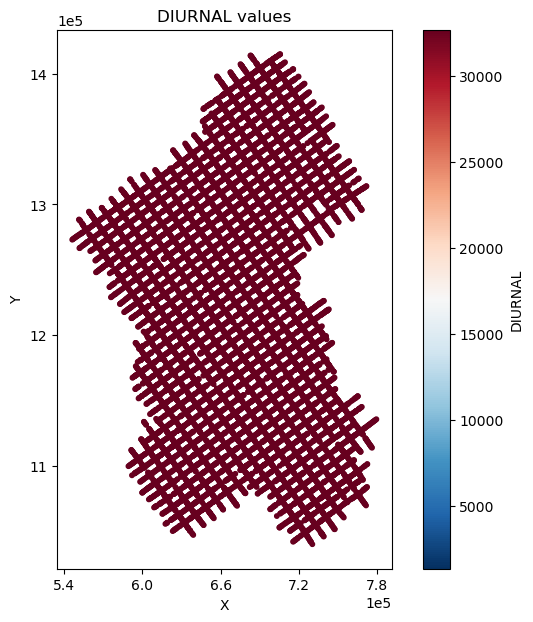

In [8]:
plt.figure(figsize=(8,7))
var = 'DIURNAL'
df_sample[var] = np.where(df_sample[var] == 0.0, np.nan, df_sample[var])
vmin = (df_sample[var]).min()
vmax = (df_sample[var]).max()
plt.scatter(df_sample['X'], df_sample['Y'], cmap='RdBu_r', c=df_sample[var], s=10, vmin=vmin, vmax=1500)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label=var)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(5,5))
plt.ticklabel_format(style='sci', axis='y', scilimits=(5,5))
plt.title(f'{var} values')
plt.show()

Block line 139127.0 has all NaN DIURNAL values.


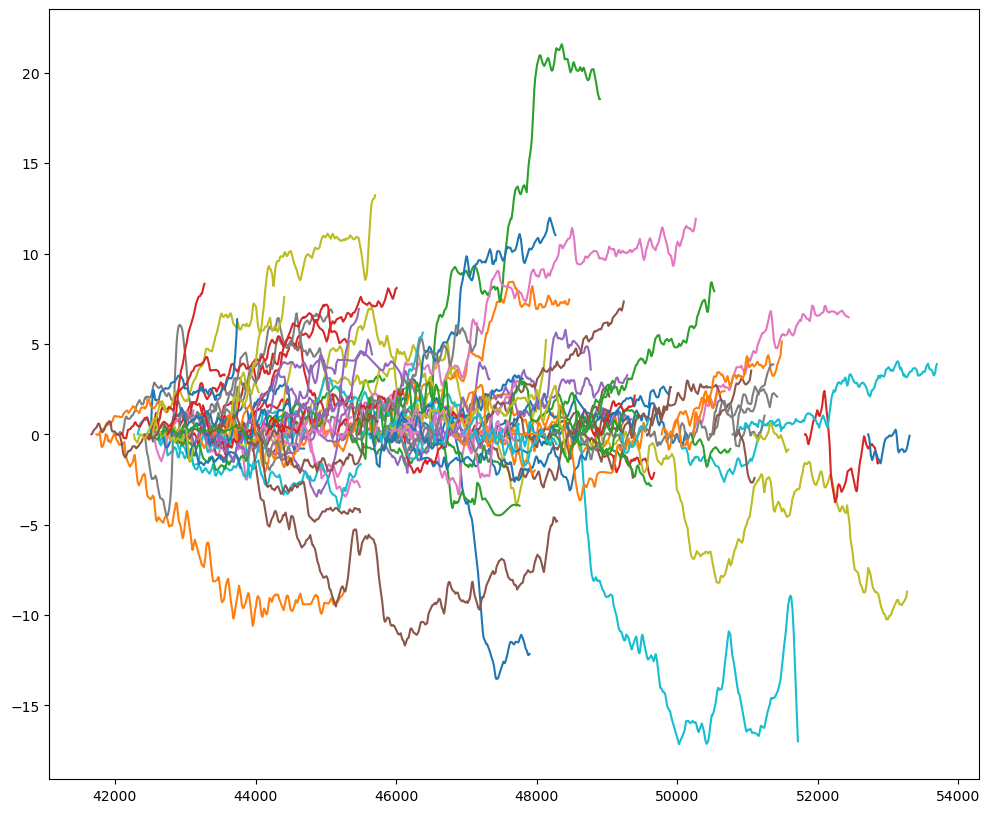

In [9]:
plt.figure(figsize=(12, 10))
ref_values = []
for block in block_values:
    df_block = df_sample[df_sample['block'] == block]
    df_block = df_block.sort_values('TIME_sec')
    
    # Encuentra el índice del primer valor no-NaN
    first_valid_idx = df_block['DIURNAL'].first_valid_index()
    
    # Obtiene el valor de referencia si existe, si no, usa NaN
    if first_valid_idx is not None:
        reference_value = df_block.loc[first_valid_idx, 'DIURNAL']
    else:
        reference_value = np.nan
        print(f'Block {block} has all NaN DIURNAL values.')

    ref_values.append(reference_value)
    # reference_value = df_block['DIURNAL'].values.mean()
    df_block['DIURNAL_variation'] = df_block['DIURNAL'] - reference_value
    # df_block['DIURNAL_variation'] = np.mean(df_block['DIURNAL'] - reference_value)
    df_block['DIURNAL_variation'] = df_block['DIURNAL_variation'].fillna(0)
    df_sample.loc[df_sample['block'] == block, 'DIURNAL_variation'] = df_block['DIURNAL_variation']
    plt.plot(df_block['TIME_sec'], df_block['DIURNAL_variation'], label=block)

In [10]:
df_sample;

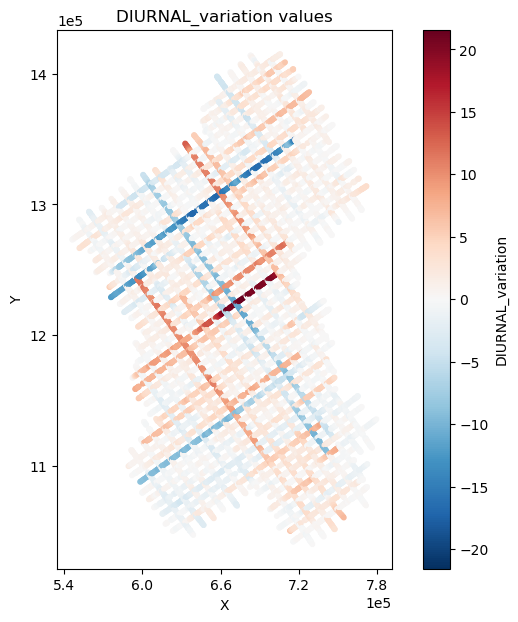

In [11]:
plt.figure(figsize=(8,7))
var = 'DIURNAL_variation'
vmin = (df_sample[var]).min()
vmax = (df_sample[var]).max()
plt.scatter(df_sample['X'], df_sample['Y'], cmap='RdBu_r', c=df_sample[var], s=10, vmin=-vmax, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label=var)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(5,5))
plt.ticklabel_format(style='sci', axis='y', scilimits=(5,5))
plt.title(f'{var} values')
plt.show()

In [12]:
df_sample['delta_altitude'] = df_sample['RAW_ALT'] - df_sample['RAW_ALT'].min()

In [13]:
df_sample['RMI'] = df_sample['OBSMAG'] - df_sample['IGRF'] - df_sample['DIURNAL_variation']

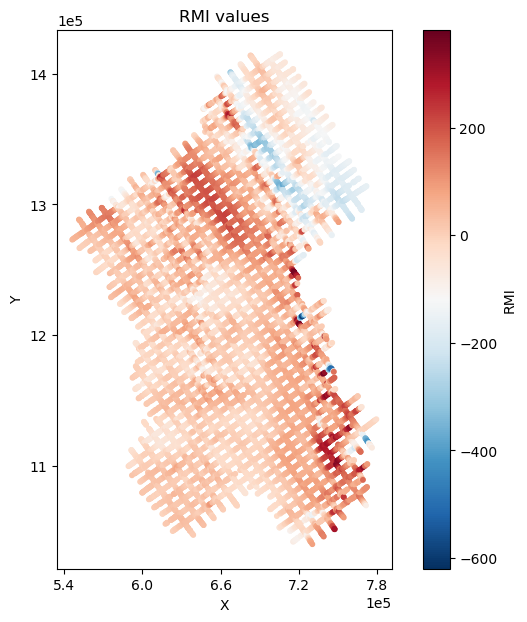

In [14]:
plt.figure(figsize=(8,7))
var = 'RMI'
vmin = df_sample[var].min()
vmax = df_sample[var].max()
plt.scatter(df_sample['X'], df_sample['Y'], cmap='RdBu_r', c=df_sample[var], s=10, vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label=var)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(5,5))
plt.ticklabel_format(style='sci', axis='y', scilimits=(5,5))
plt.title(f'{var} values')
plt.show()

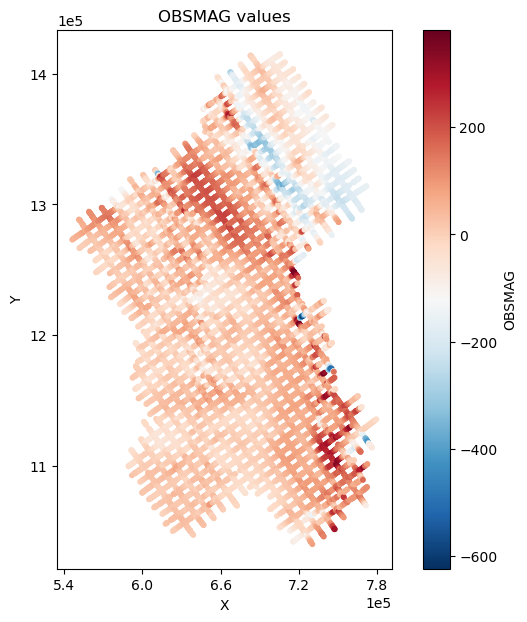

In [15]:
plt.figure(figsize=(8,7))
var = 'OBSMAG'
vmin = (df_sample[var]-df_sample['IGRF']).min()
vmax = (df_sample[var]-df_sample['IGRF']).max()
plt.scatter(df_sample['X'], df_sample['Y'], cmap='RdBu_r', c=df_sample[var]-df_sample['IGRF'], s=10, vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label=var)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(5,5))
plt.ticklabel_format(style='sci', axis='y', scilimits=(5,5))
plt.title(f'{var} values')
plt.show()

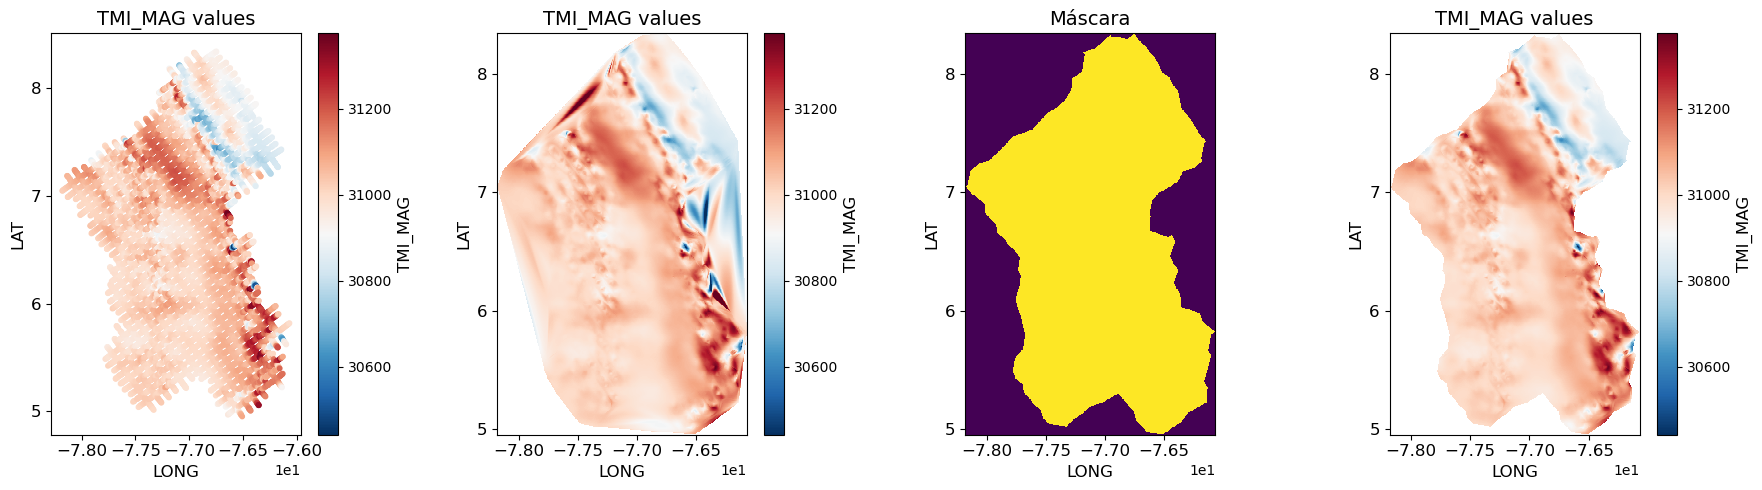

In [16]:
grid_x, grid_y, data_interpolated, data_masked, inside_mask = interpolate.interpolate_data(df_sample, 'TMI_MAG', coords_type = ('LONG', 'LAT'), alpha=10)
interpolate_plotting.plot_interpolated_data(df_sample, grid_x, grid_y, data_interpolated, data_masked, inside_mask, 'TMI_MAG', cmap='RdBu_r', coords_type = ('LONG', 'LAT'))
# plt.savefig(f'../output/figures/{var}_interpolated.png', dpi=300)

# Gravity data

In [17]:
blocks = []
block_ids = []

with open('../../data/gravity/PAC_GRAV_NORTE/PAC_GRAV_NORTE.xyz') as f:
    lines = f.readlines()

columns = lines[1].strip().split()
current_block = None

for line in lines[2:]:
    if line.startswith('line'):
        current_block = line.strip()
        continue
    values = line.strip().split()
    if len(values) == len(columns):
        blocks.append(values)
        block_ids.append(current_block)

df = pd.DataFrame(blocks, columns=columns)
df['block'] = block_ids
df;

In [18]:
df = df.astype({
    '/FID': int,
    'JDAY': int,
    'TIME': float,
    'X': float,
    'Y': float,
    'LAT': float,
    'LONG': float,
    'RAW_ALT': float,
    'ADJ_ALT': float,
    'RADAR': float,
    'TERRAIN': float,
    'RAW_VERTACC': float,
    'RAW_BEAMDIFF': float,
    'ADJSPTEN': float,
    'FACORR': float,
    'LATCORR': float,
    'RAWEOTV': float,
    'FILT_EOTV': float,
    'FREEAIR': float,
    'TCOR230': float,
    'BOUG230': float,
    'TCOR267': float,
    'BOUG267': float,
    'block': str
})

In [19]:
df_sorted = df.sort_values('X')
df_sample = df_sorted.iloc[::10].copy()
df_sample;

In [20]:
block_values = df_sample['block'].unique()
block_values;

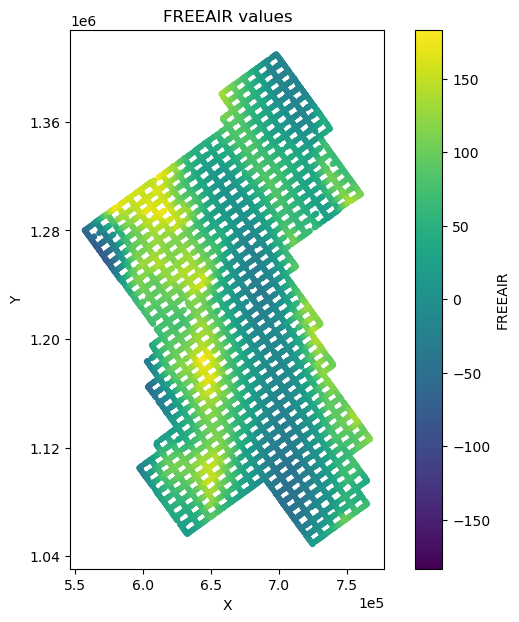

In [21]:
plt.figure(figsize=(8,7))

# var, cmap = 'FACORR', 'viridis'
# vmin = df_sample[var].min()
# vmax = df_sample[var].max()

var, cmap = 'FREEAIR', 'viridis'
# var, cmap = 'BOUG267', 'bwr'
vmax = np.abs(df_sample[var]).max()
vmin = -vmax

coords_type = ('LONG', 'LAT')

plt.scatter(df_sample['X'], df_sample['Y'], c=df_sample[var], s=10, vmin=vmin, vmax=vmax, cmap=cmap)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label=var)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(1,5))
plt.ticklabel_format(style='sci', axis='y', scilimits=(1,5))
plt.title(f'{var} values')
plt.show()

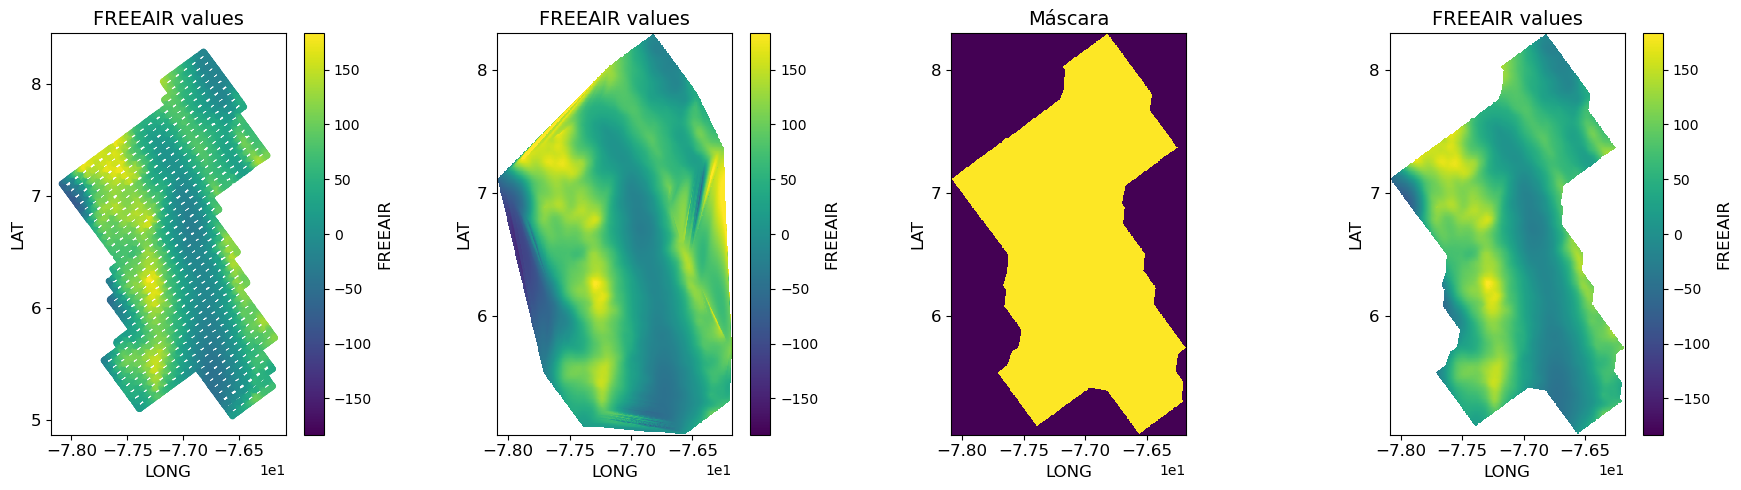

In [22]:
grid_x, grid_y, data_interpolated, data_masked, inside_mask, shape = interpolate.interpolate_data(df_sample, var, coords_type = coords_type, alpha=10, return_shape=True)
interpolate_plotting.plot_interpolated_data(df_sample, grid_x, grid_y, data_interpolated, data_masked, inside_mask, var, coords_type = coords_type, cmap=cmap, vmax=vmax, vmin=vmin)
# plt.savefig(f'../output/figures/{var}_interpolated.png', dpi=300)

Shapefile guardado en: ..\..\output/masks/mask_of_gravity_data.shp


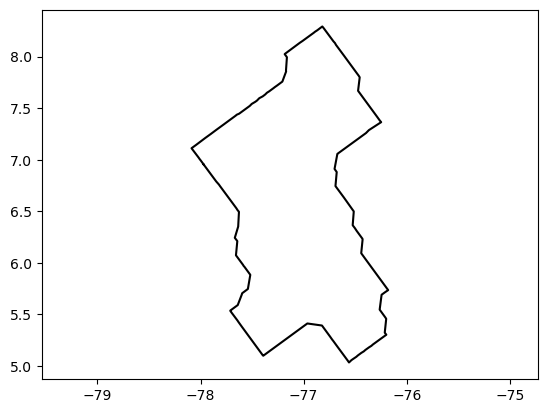

In [23]:
plt.figure()
bnd = shape.boundary
x, y = bnd.xy
plt.plot(x, y, color="k", lw=1.5, zorder=10)
ax = plt.gca()
ax.set_aspect('equal', 'datalim')

geom = shape if isinstance(shape, (Polygon, MultiPolygon)) else shape.buffer(0)

gdf_shape = gpd.GeoDataFrame(
    {"name": ["alphashape"]},
    geometry=[geom],
    crs="EPSG:4326"
)

out_path = output_dir + "/masks/mask_of_gravity_data.shp"
gdf_shape.to_file(out_path, driver="ESRI Shapefile")
print(f"Shapefile guardado en: {out_path}")

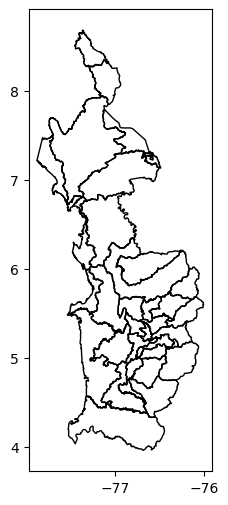

In [24]:
import geopandas as gpd
filename = '../../data/vector/colombia/Municipio, Distrito y Area no municipalizada.shp' # Data taken from colombiaenmapas.gov.co
gdf = gpd.read_file(filename)
gdf = gdf.to_crs(epsg=4326)
depto = gdf[gdf['Depto'] == 'Chocó']
depto.plot(figsize=(8,6), edgecolor='black', facecolor='none')
plt.show()

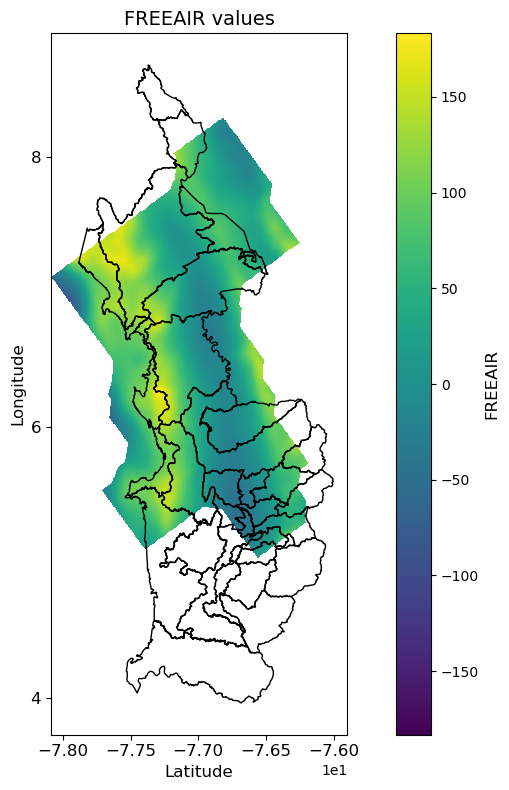

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.pcolormesh(grid_x, grid_y, data_masked.reshape((grid_x.shape)), cmap='viridis', vmin=vmin, vmax=vmax)
depto.plot(ax=ax, edgecolor='black', facecolor='none')

cb = plt.colorbar(im, ax=ax)
cb.set_label(var, fontsize=12)
ax.set_title(f'{var} values', fontsize=14)
ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
ax.set_aspect('equal', adjustable='box')
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,5))
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,5))

fig.tight_layout()
plt.show()